### Import

In [1]:
import pandas as pd
import numpy as np
import csv
import re

from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

from matplotlib import pyplot as plt
%matplotlib inline

### Parametere

In [2]:
n_clusters=5
#type='Interesse' 
type='Kompetanse'


### Funksjoner

In [211]:
cat = ['IM', 'ITST', 'BST', 'Tverrfaglige kompetanser']
colors = ['b', 'r', 'y', 'g']

def group_variables(df, cats):
    
    ucats = set([])
    col2cat = {}
    subcat2cat = {}
    
    # Hent kompetansekategoriseringen og lagre i col2cat og ucats
    with open('Kategorier kompetanse og interesser.csv', 'r') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader, None)
        for row in reader:
            col2cat[row[0]] = {'Kategori': row[1], 'Underkategori': row[2]}
            subcat2cat[row[2]] = row[1]
            ucats.add(row[2])
    
    # Lag nytt datasett med variabler som er snittet i hver underkategori
    dfc = df.reset_index()[['Navn', 'Team']]
    for ucat in ucats:
        col_subset = np.matrix(df[[col for col in df.columns if col2cat[col]['Underkategori'] == ucat]])
        dfc_add = pd.DataFrame(col_subset.sum(1)/col_subset.shape[1], columns=[ucat])
        dfc = pd.concat([dfc, dfc_add], axis=1)
        
    dfc.set_index(['Navn','Team'],inplace=True)
        
    return dfc, subcat2cat

def do_pca(df):
    pca = PCA(n_components=2)
    dfs = preprocessing.scale(ndf,with_std=False)
    pca.fit(dfs)
    transformed_df = pca.transform(dfs)
    newdf = pd.concat([df.reset_index()[['Navn', 'Team']], pd.DataFrame(transformed_df)], axis=1)
    components = pd.concat([df.transpose().reset_index()['index'], pd.DataFrame({'1':pca.components_[0]}), pd.DataFrame({'2':pca.components_[1]})], axis=1).set_index('index')
    return newdf, components


def plot_pca(df):
    ms = 90
    ax = df[df['Team']=='IM'].plot(kind='scatter', x=0, y=1, s=ms, color='b', label='IM', figsize=(8,8))
    df[df['Team']=='BST' ].plot(kind='scatter', x=0, y=1, s=ms, color='r', label='BST', ax=ax)
    df[df['Team']=='ITST'].plot(kind='scatter', x=0, y=1, s=ms, color='y', label='ITST', ax=ax)

    for navn, team, x, y in df.values:
        if team == 'IM':
            horz = 'right'
        else:
            horz = 'left'
        shortname = re.match('([A-Za-z]+)\,?', navn).group(1)
        plt.annotate(shortname, xy=(x, y), textcoords = 'offset points', xytext = (0,8), horizontalalignment = horz)
    
    plt.title('PCA-analyse av %s' % type)
    pass

def plot_top_components(components, ind):
    
    a = max(abs(components[str(ind)]))
    
    plt.figure()
    components_sorted = components.sort(str(ind))[str(ind)]
    subset = pd.concat([components_sorted[:3],components_sorted[-3:]])
    subset.plot(kind='barh', xlim=(-1.1*a,1.1*a), figsize=(8,6), title='PCA component ' + str(ind));

    pass

def plot_influential_variables(components, cat, subcat2cat, i):
    
    N = len(components[str(i)])
    amp = max(abs(components[str(i)]))
    
    
    values = components[str(i)].order()
    names = [a for a in values.index]
    names_2 = []
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    ind = range(N)
    width = 0.5
    margin = 0.02
    
    rects = []
    for k,c in enumerate(cat):
        cind = [i for i in xrange(N) if subcat2cat[names[i]] == c]
        rects.append(ax.barh([ind[j] for j in cind], [values[j] for j in cind], width, color=colors[k]))
        names_2 += [names[j] for j in cind]
    
    #ax.set_ylabel('Scores')
    #ax.set_title('Scores by group and gender')
    #ax.set_xticks(ind+width)
    #ax.set_xticklabels( ('G1', 'G2', 'G3', 'G4', 'G5') )
    
    # Text labels
    j = 0
    # For hvert sett av rektangler
    for rect in rects:
        # For hver rektangel
        for r in rect:
            
            if r.get_x() < 0:
                x = r.get_x() - margin
                ha = 'right'
            else:
                x = r.get_width() + margin
                ha = 'left'
            y = r.get_y() + width/2.
            
            s = names_2[j] + ' (%.2f)' % x
            
            ax.text(x, y, s, ha=ha, va='center')
            j += 1
        
    ax.set_xbound(-1.1*amp,1.1*amp)
    ax.set_ybound(-1,N)
    
    ax.axis('off')
    
    ax.legend(cat[:3] + ['Tverrfaglig'], bbox_to_anchor=(1.15, 0.03), loc=4)
    
    pass
    
    
    

### Datasett

In [147]:
# Last datasett
df = pd.io.parsers.read_csv(type+"_formatert.csv", sep=';', index_col=[0,1])

# Dropp rader med manglende verdier
df.dropna(how='any', inplace=True)

# Last kategoriseringer av variable
cats = pd.io.parsers.read_csv('Kategorier kompetanse og interesser.csv', sep=';')

# Lag nytt datasett med grupperte variable
ndf, subcat2cat = group_variables(df, cats)

### PCA-analyse

In [5]:
newdf, components = do_pca(ndf)

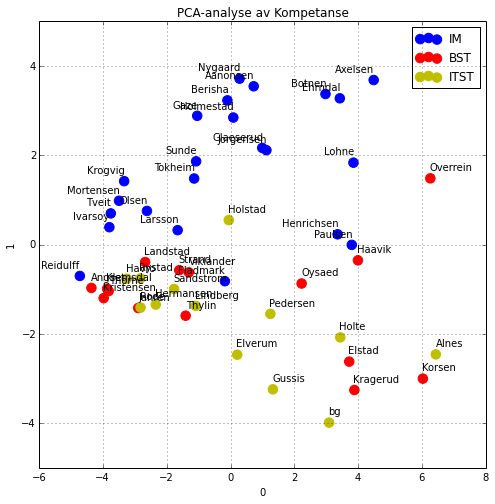

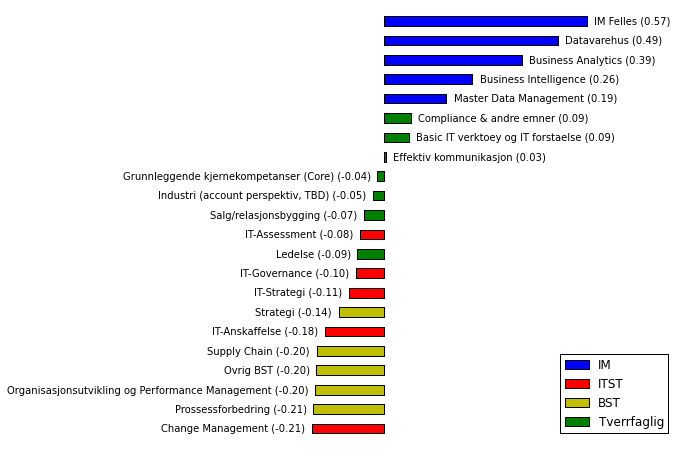

In [214]:
# Scatter plot
plot_pca(newdf)

# Bar charts av komponenter
plot_influential_variables(components, cat, subcat2cat, 2)
